In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
df = pd.read_csv("../csv/debug.csv")
df.head()

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0


In [29]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['attrition'].value_counts())

Dataset Shape: (300, 11)

Data Types:
age                    int64
gender                object
education             object
department            object
job_role              object
monthly_income         int64
years_at_company       int64
promotions             int64
overtime              object
performance_rating     int64
attrition              int64
dtype: object

Missing Values:
age                   0
gender                0
education             0
department            0
job_role              0
monthly_income        0
years_at_company      0
promotions            0
overtime              0
performance_rating    0
attrition             0
dtype: int64

Target Distribution:
attrition
0    231
1     69
Name: count, dtype: int64


In [30]:
# --- Feature Engineering (BROKEN ON PURPOSE) ---
# 1) Create a feature that directly uses the target (leakage disguised as a helper feature)

df["attrition_copy"] = df["attrition"]  # <-- target copied into features

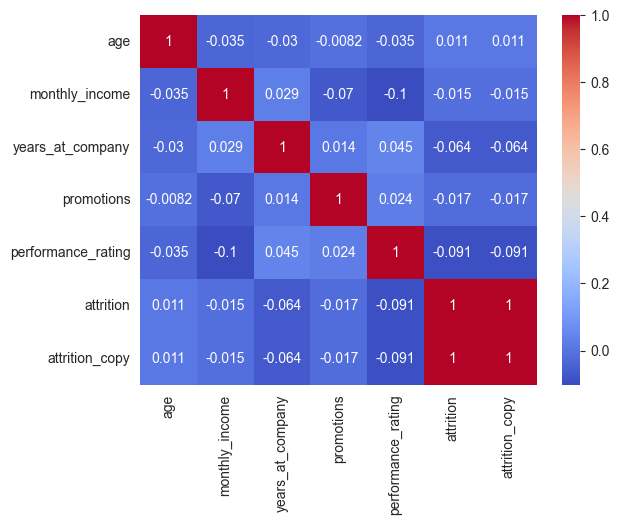

In [31]:
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=True)
plt.show()

In [32]:
# we can see that attrition and attrition copy are exacrly the same. so we will be removing it

In [33]:
df.drop("attrition_copy", axis=1)

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0
...,...,...,...,...,...,...,...,...,...,...,...
295,53,Female,Post-Graduate,Finance,Manager,106988,2,1,No,1,0
296,43,Male,Graduate,Sales,Executive,65648,10,1,No,4,0
297,44,Female,Post-Graduate,HR,Lead,29516,5,0,Yes,3,0
298,23,Female,Graduate,Sales,Executive,22396,8,4,No,4,0


In [34]:
X = df.drop("attrition", axis=1)
y = df["attrition"]

In [45]:
X = X.drop("attrition_copy", axis=1)
X

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3
...,...,...,...,...,...,...,...,...,...,...
295,53,Female,Post-Graduate,Finance,Manager,106988,2,1,No,1
296,43,Male,Graduate,Sales,Executive,65648,10,1,No,4
297,44,Female,Post-Graduate,HR,Lead,29516,5,0,Yes,3
298,23,Female,Graduate,Sales,Executive,22396,8,4,No,4


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

In [48]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [49]:
# Now let's train the final model without leakage
pipe.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87        70
           1       0.00      0.00      0.00        20

    accuracy                           0.77        90
   macro avg       0.39      0.49      0.43        90
weighted avg       0.60      0.77      0.68        90



In [50]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')

print(f"\nIndividual Fold Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation: {cv_scores.std() * 100:.2f}%")


Individual Fold Scores: [0.80952381 0.76190476 0.76190476 0.73809524 0.76190476]
Mean CV Accuracy: 76.67%
Standard Deviation: 2.33%


In [51]:
import joblib
joblib.dump(pipe, "final_model.pkl")

['final_model.pkl']